In [ ]:
# RUN ONCE
#!pip install pandas numpy scipy matplotlib seaborn scikit-learn imbalanced-learn transformers torch

In [1]:
# Jobenn Bezuidenhout u22518500
# IMPORTS
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE  
from transformers import BertTokenizer, BertModel
import torch

# Set plot style
sns.set(style="whitegrid")

In [ ]:
# LOAD DATASETS
# Load UGRansome 
ugr_df = pd.read_csv('../Data/UGRansome.csv') 

# Load PM 
pm_df = pd.read_csv('../Data/PM.csv')

# Print shapes and heads
print("UGRansome shape:", ugr_df.shape)
print(ugr_df.head())
print("\nPM shape:", pm_df.shape)
print(pm_df.head())

# Inspect columns and unique values for labels
print("\nUGRansome columns:", ugr_df.columns.tolist())
print("UGRansome unique values in prediction:", ugr_df['prediction'].unique())

print("\nPM columns:", pm_df.columns.tolist())
print("PM unique values in label:", pm_df['label'].unique())

# Standardize labels
ugr_df['label'] = ugr_df['prediction']

# Verify no NaNs in label
print("UGRansome label unique values after fix:", ugr_df['label'].unique())
print("UGRansome label is all NaN:", ugr_df['label'].isnull().all())
print("PM label unique values after fix:", pm_df['label'].unique())
print("PM label is all NaN:", pm_df['label'].isnull().all())

UGRansome shape: (10000, 14)
  protocol flag     family   address    usd seed_address  btc  netflow_bytes  \
0      TCP  APS       Razy  1DiCeTjB      1     17dcMo4V   16            224   
1      TCP    R     SamSam  1SYSTEMQ  18111     1DA11mPS   22           4981   
2      UDP   AP     SamSam  1SYSTEMQ  18454     1DA11mPS   11           2251   
3      UDP   AF  DMALocker  1DiCeTjB      1     1GZkujBR   20            307   
4      UDP   AF        APT  18e372GN   2264     1GZkujBR   28             38   

  ip_address  clusters        threats  port  time  prediction  
0          B         9           Scan  5066     3      Benign  
1          C         1  Port Scanning  5066     6      Benign  
2          C         1      Blacklist  5062    58  Ransomware  
3          A         1           Spam  5061    45  Ransomware  
4          A         2  Port Scanning  5068     9      Benign  

PM shape: (10186, 9)
     r   rw  rx  rwc  rwx  rwxc    category    family       label
0   69   71  26   

In [3]:
# DATA CLEANING
# For both datasets: Identify missing values
print("UGRansome missing:\n", ugr_df.isnull().sum())
print("PM missing:\n", pm_df.isnull().sum())

# Impute missing numerical with mean, categorical with mode
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# UGRansome: Categorize features
ugr_num_cols = ['time', 'btc', 'usd', 'netflow_bytes', 'port'] 
ugr_cat_cols = ['protocol', 'flag', 'family', 'address', 'seed_address', 'ip_address', 'clusters', 'threats', 'prediction', 'label']  

# Exclude all-missing columns to avoid shape mismatch
ugr_cat_cols = [col for col in ugr_cat_cols if col in ugr_df.columns and not ugr_df[col].isnull().all()]
print("UGRansome cat_cols after exclusion:", ugr_cat_cols)

ugr_df[ugr_num_cols] = num_imputer.fit_transform(ugr_df[ugr_num_cols])
ugr_df[ugr_cat_cols] = cat_imputer.fit_transform(ugr_df[ugr_cat_cols])

# PM: All numerical except label/category, lowercase/matched to PDF and your columns
pm_num_cols = ['r', 'rw', 'rx', 'rwc', 'rwx', 'rwxc']
pm_cat_cols = ['category', 'family', 'label']  

# Exclude all-missing for PM
pm_cat_cols = [col for col in pm_cat_cols if col in pm_df.columns and not pm_df[col].isnull().all()]
print("PM cat_cols after exclusion:", pm_cat_cols)

pm_df[pm_num_cols] = num_imputer.fit_transform(pm_df[pm_num_cols])
pm_df[pm_cat_cols] = cat_imputer.fit_transform(pm_df[pm_cat_cols])

# Handle outliers (e.g., clip to 1-99 percentile for numerical)
for col in ugr_num_cols:
    ugr_df[col] = np.clip(ugr_df[col], ugr_df[col].quantile(0.01), ugr_df[col].quantile(0.99))

for col in pm_num_cols:
    pm_df[col] = np.clip(pm_df[col], pm_df[col].quantile(0.01), pm_df[col].quantile(0.99))

# Feature categorization table (use updated cols)
feature_table = pd.DataFrame({
    'Dataset': ['UGRansome'] * len(ugr_num_cols + ugr_cat_cols) + ['PM'] * len(pm_num_cols + pm_cat_cols),
    'Feature': ugr_num_cols + ugr_cat_cols + pm_num_cols + pm_cat_cols,
    'Type': ['Numerical'] * len(ugr_num_cols) + ['Categorical'] * len(ugr_cat_cols) + ['Numerical'] * len(pm_num_cols) + ['Categorical'] * len(pm_cat_cols)
})
print(feature_table)

UGRansome missing:
 protocol         0
flag             0
family           0
address          0
usd              0
seed_address     0
btc              0
netflow_bytes    0
ip_address       0
clusters         0
threats          0
port             0
time             0
prediction       0
label            0
dtype: int64
PM missing:
 r              0
rw             0
rx             0
rwc            0
rwx            0
rwxc           0
category       0
family      1364
label          0
dtype: int64
UGRansome cat_cols after exclusion: ['protocol', 'flag', 'family', 'address', 'seed_address', 'ip_address', 'clusters', 'threats', 'prediction', 'label']
PM cat_cols after exclusion: ['category', 'family', 'label']
      Dataset        Feature         Type
0   UGRansome           time    Numerical
1   UGRansome            btc    Numerical
2   UGRansome            usd    Numerical
3   UGRansome  netflow_bytes    Numerical
4   UGRansome           port    Numerical
5   UGRansome       protocol  Catego

UGRansome stats:
                  usd           btc  netflow_bytes          port          time
count   10000.000000  10000.000000   10000.000000  10000.000000  10000.000000
mean    14560.599900     25.989200    2027.617700   5063.906000     21.547300
std     26564.663814     47.118535    2260.143117      2.674786     15.843638
min         1.000000      2.000000      13.990000   5061.000000      1.000000
25%       495.750000      8.000000     366.000000   5062.000000      8.000000
50%      3044.500000     13.000000    1038.500000   5062.000000     19.000000
75%     18454.000000     22.000000    3198.500000   5066.000000     32.000000
max    126123.040000    306.020000   10424.200000   5068.000000     58.000000
PM stats:
                   r            rw            rx           rwc           rwx  \
count  10186.000000  10186.000000  10186.000000  10186.000000  10186.000000   
mean      99.757216    115.271942     37.498429     32.947281     15.214314   
std       75.684988    104.59426

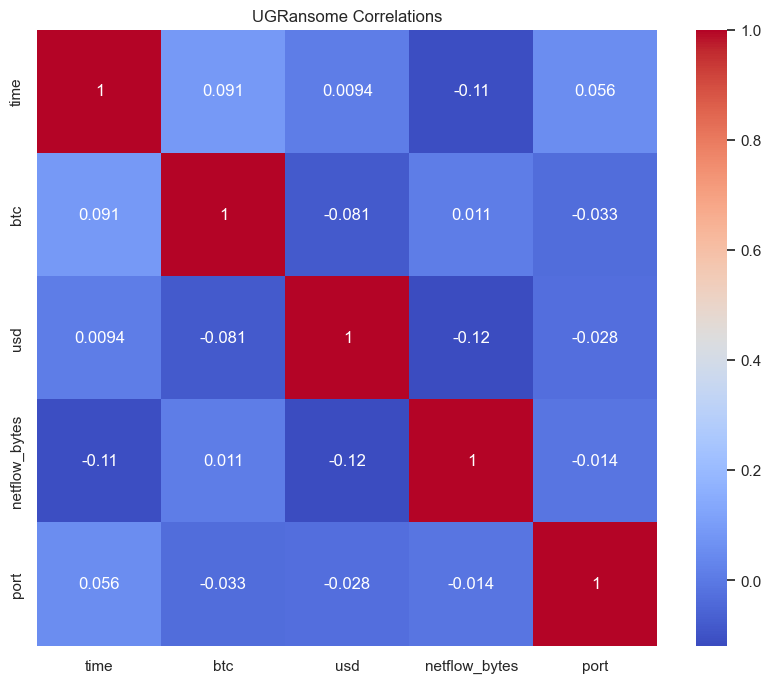

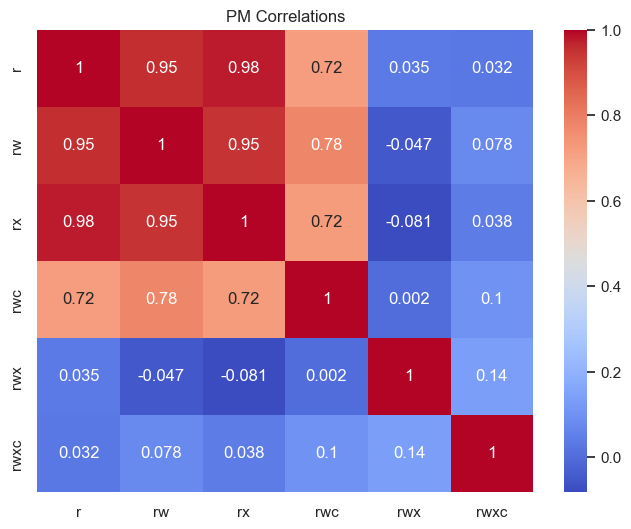

UGRansome class distribution:
 label
Ransomware    0.506
Benign        0.494
Name: proportion, dtype: float64
PM class distribution:
 label
Ransomware    0.936776
Benign        0.063224
Name: proportion, dtype: float64


In [4]:
# EDA AND BASIC STATISTICS
# Summary stats
print("UGRansome stats:\n", ugr_df.describe())
print("PM stats:\n", pm_df.describe())

# Correlations (on numerical)
ugr_corr = ugr_df[ugr_num_cols].corr()
pm_corr = pm_df[pm_num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(ugr_corr, annot=True, cmap='coolwarm')
plt.title('UGRansome Correlations')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pm_corr, annot=True, cmap='coolwarm')
plt.title('PM Correlations')
plt.show()

# Class imbalance
print("UGRansome class distribution:\n", ugr_df['label'].value_counts(normalize=True))
print("PM class distribution:\n", pm_df['label'].value_counts(normalize=True))

In [5]:
# NUMERICAL-TO-TEXT TRANSFORMATION
# Innovate: Bin numerical into 3 bins (low/medium/high), convert to text
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

# UGRansome
ugr_binned = discretizer.fit_transform(ugr_df[ugr_num_cols])
ugr_binned_df = pd.DataFrame(ugr_binned, columns=[f"{col}_binned" for col in ugr_num_cols])
ugr_binned_df = ugr_binned_df.replace({0: 'low', 1: 'medium', 2: 'high'})

# Combine with categorical to create text
ugr_df['text'] = ugr_binned_df.apply(lambda row: ' '.join([f"{col}: {row[f'{col}_binned']}" for col in ugr_num_cols]), axis=1) + \
                 ' ' + ugr_df[ugr_cat_cols[:-1]].astype(str).apply(' '.join, axis=1)  

# PM 
pm_binned = discretizer.fit_transform(pm_df[pm_num_cols])
pm_binned_df = pd.DataFrame(pm_binned, columns=[f"{col}_binned" for col in pm_num_cols])
pm_binned_df = pm_binned_df.replace({0: 'low', 1: 'medium', 2: 'high'})

pm_df['text'] = pm_binned_df.apply(lambda row: ' '.join([f"{col}: {row[f'{col}_binned']}" for col in pm_num_cols]), axis=1) + \
                ' ' + pm_df['category'].astype(str) + ' ' + pm_df['family'].astype(str)  

# Add segment embeddings (EA for PM, EB for UGR)
pm_df['segment'] = 'EA'
ugr_df['segment'] = 'EB'

# Show samples
print("UGRansome before/after:\n", ugr_df[ugr_num_cols + ['text']].head(2))
print("PM before/after:\n", pm_df[pm_num_cols + ['text']].head(2))

UGRansome before/after:
    time   btc      usd  netflow_bytes    port  \
0   3.0  16.0      1.0          224.0  5066.0   
1   6.0  22.0  18111.0         4981.0  5066.0   

                                                text  
0  time: low btc: low usd: low netflow_bytes: low...  
1  time: low btc: low usd: low netflow_bytes: med...  
PM before/after:
        r     rw    rx   rwc  rwx  rwxc  \
0   69.0   71.0  26.0  28.0  5.0   0.0   
1  120.0  102.0  50.0  29.0  6.0   0.0   

                                                text  
0  r: low rw: low rx: low rwc: low rwx: low rwxc:...  
1  r: medium rw: low rx: medium rwc: low rwx: low...  


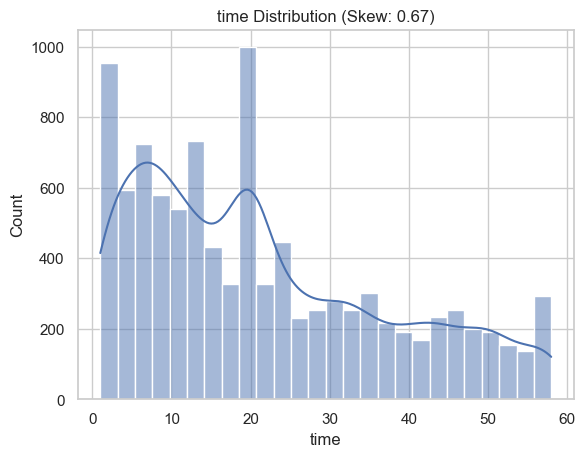

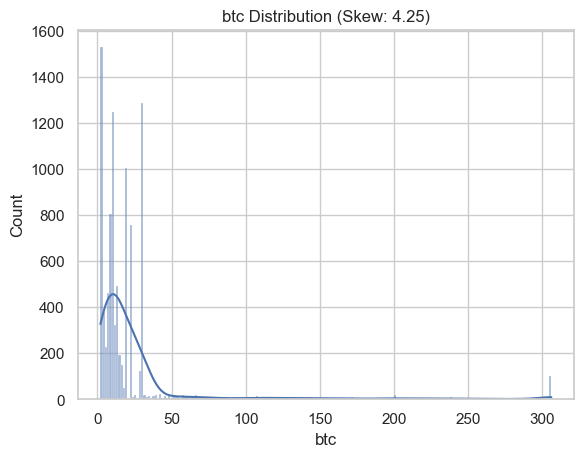

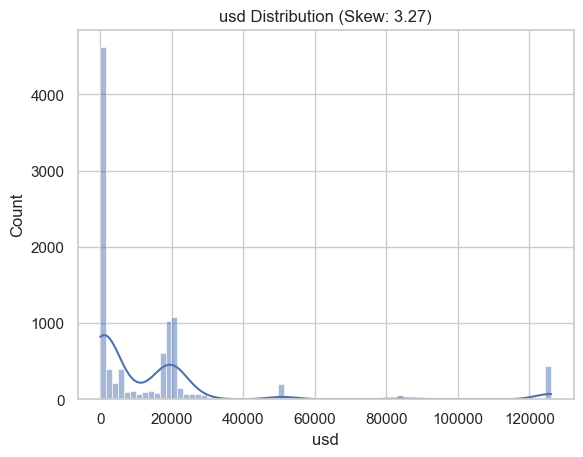

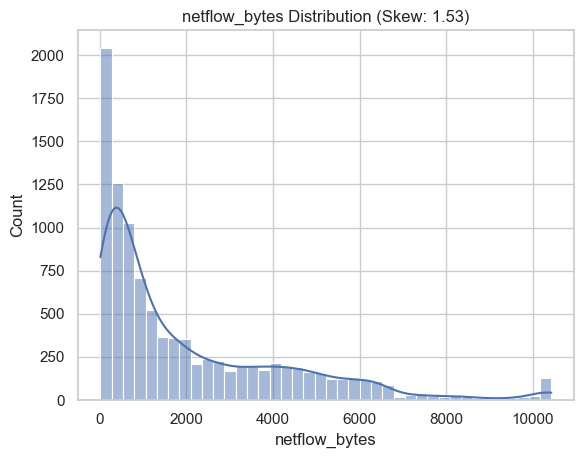

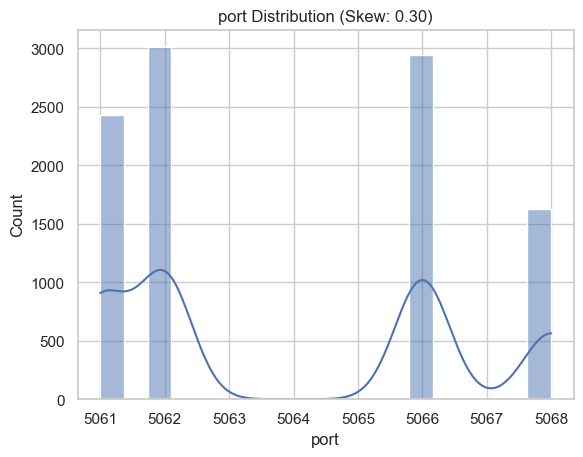

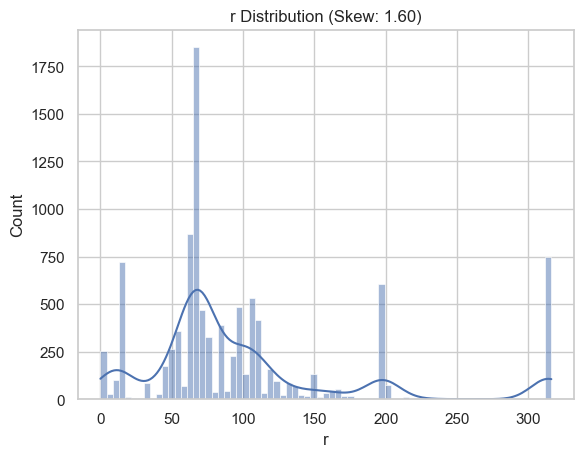

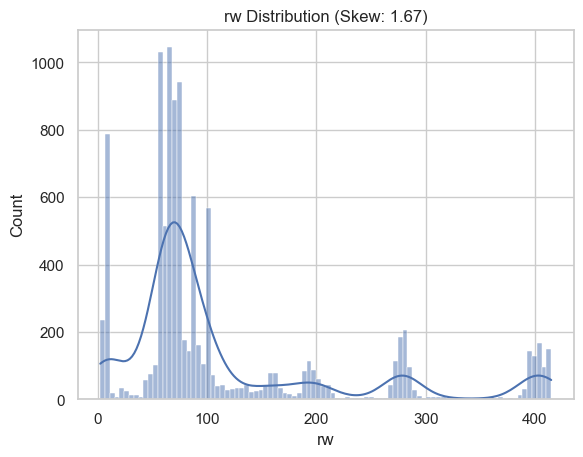

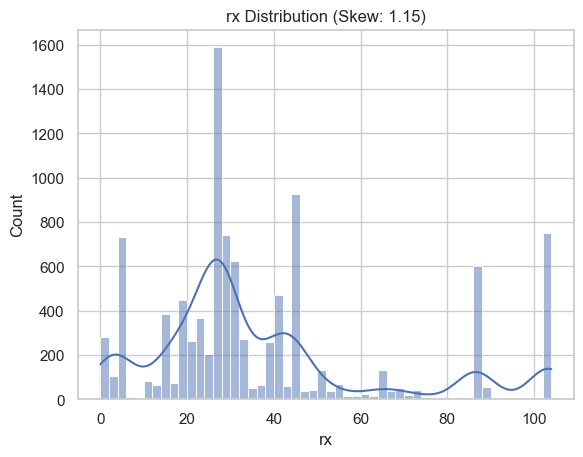

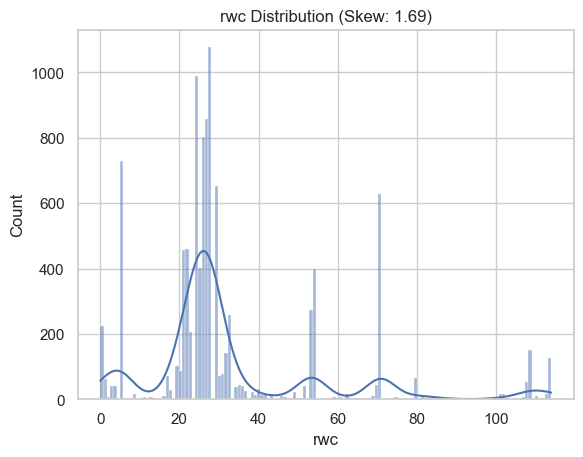

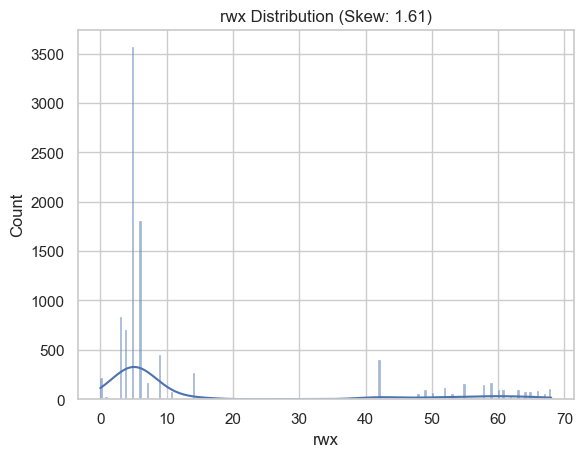

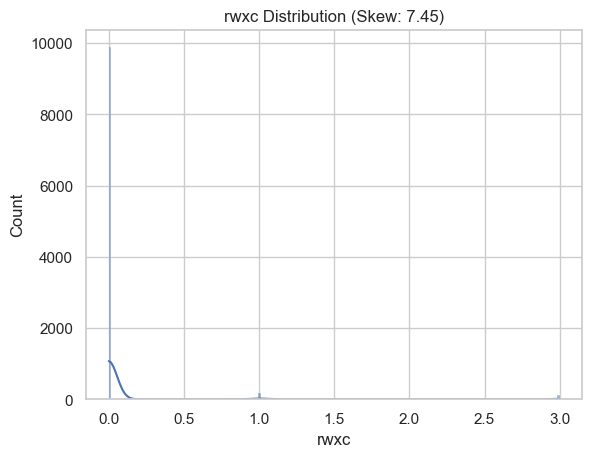

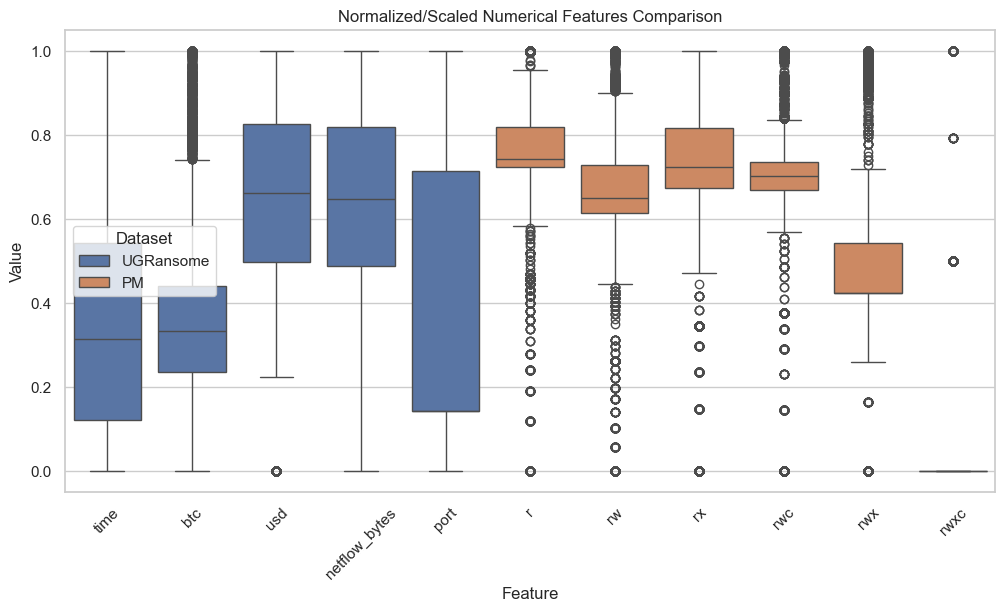

In [6]:
# NORMALIZATION AND SCALING
# Check skewness (plot distributions)
for col in ugr_num_cols + pm_num_cols:
    df = ugr_df if col in ugr_num_cols else pm_df
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Distribution (Skew: {stats.skew(df[col].dropna()):.2f})")
    plt.show()

# Apply transformations to skewed (>1 or <-1 skew)
def transform_skewed(series):
    if stats.skew(series) > 1:
        return np.log1p(series)  
    elif stats.skew(series) < -1:
        return np.sqrt(series.max() - series + 1) 
    return series

for col in ugr_num_cols:
    ugr_df[col] = transform_skewed(ugr_df[col])

for col in pm_num_cols:
    pm_df[col] = transform_skewed(pm_df[col])

# Plot after
# Scale all numerical (Min-Max)
scaler = MinMaxScaler()
ugr_df[ugr_num_cols] = scaler.fit_transform(ugr_df[ugr_num_cols])
pm_df[pm_num_cols] = scaler.fit_transform(pm_df[pm_num_cols])

# Plot all normalized/scaled in one graph
all_num = pd.concat([ugr_df[ugr_num_cols].melt(var_name='Feature', value_name='Value').assign(Dataset='UGRansome'),
                     pm_df[pm_num_cols].melt(var_name='Feature', value_name='Value').assign(Dataset='PM')])

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_num, x='Feature', y='Value', hue='Dataset')
plt.title('Normalized/Scaled Numerical Features Comparison')
plt.xticks(rotation=45)
plt.show()

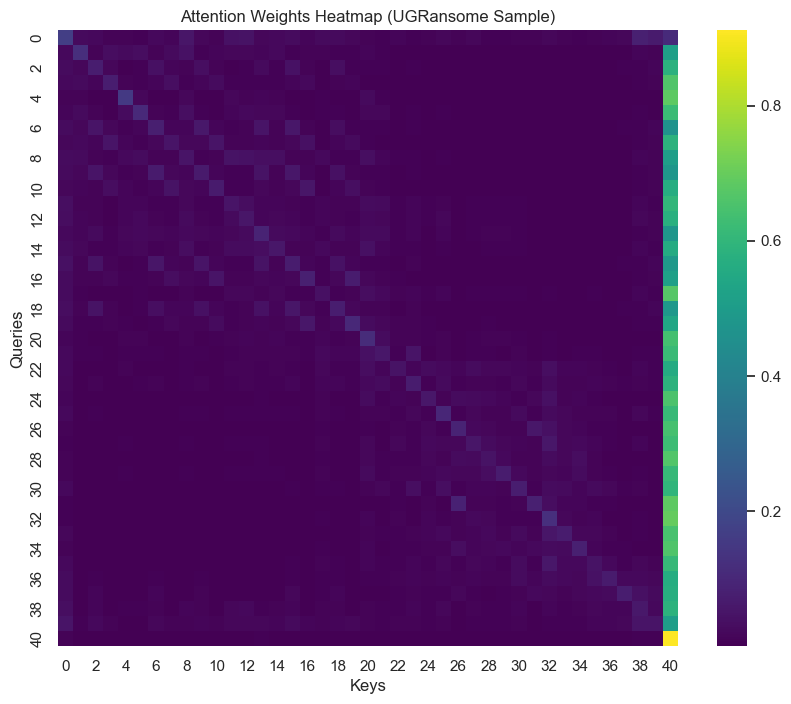

In [7]:
# EMBEDDINGS AND PREPROCESSING/ENCODING
# Generate embeddings using BERT (Hugging Face)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)  

def get_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_emb = outputs.last_hidden_state.mean(dim=1).numpy()  
        embeddings.extend(batch_emb)
    return embeddings

# Apply to text (batched for speed)
ugr_df['embeddings'] = get_embeddings_batch(ugr_df['text'].tolist())
pm_df['embeddings'] = get_embeddings_batch(pm_df['text'].tolist())

# Visualize attention weights (sample from UGRansome)
sample_text = ugr_df['text'].iloc[0]
sample_inputs = tokenizer(sample_text, return_tensors='pt')
outputs = model(**sample_inputs)
attention = outputs.attentions[-1][0].mean(dim=0).detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention, cmap='viridis')
plt.title('Attention Weights Heatmap (UGRansome Sample)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

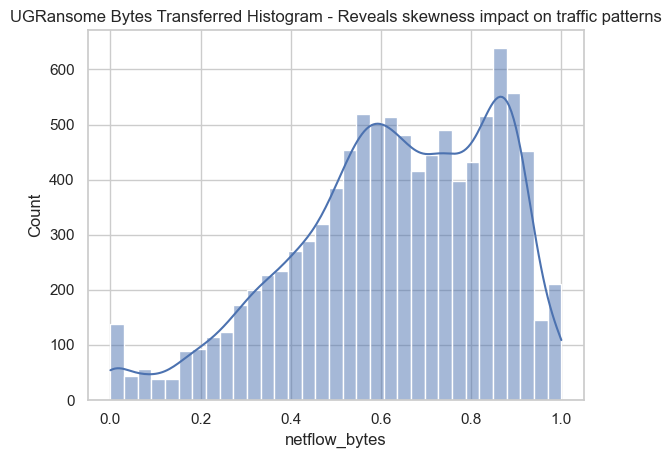

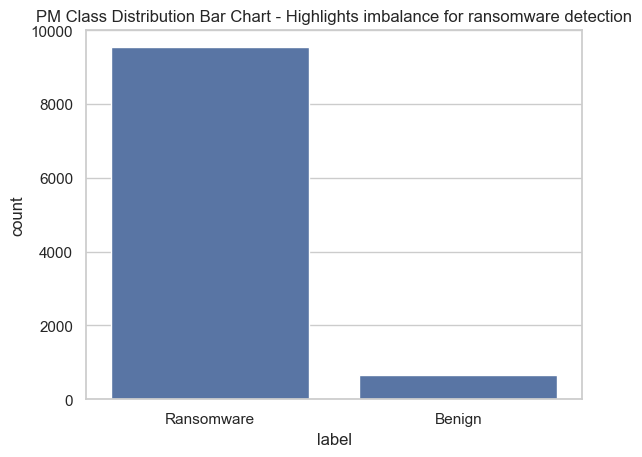

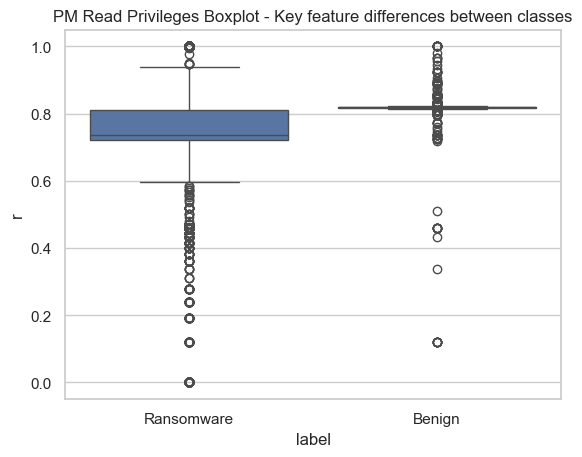

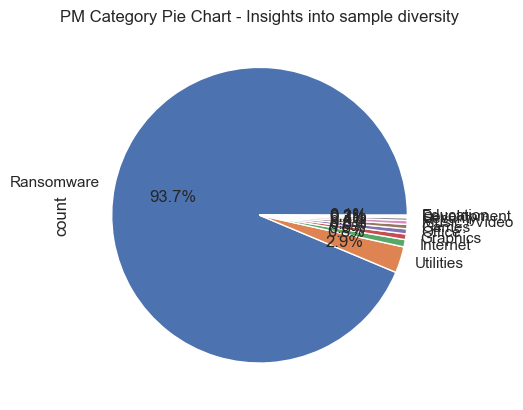

In [8]:
# DATA VISUALIZATION
# 1. Histogram: Numerical distribution
fig, ax = plt.subplots()
sns.histplot(ugr_df['netflow_bytes'], kde=True, ax=ax)
ax.set_title('UGRansome Bytes Transferred Histogram - Reveals skewness impact on traffic patterns')
plt.show()

# 2. Bar chart: Class counts
fig, ax = plt.subplots()
sns.countplot(x='label', data=pm_df, ax=ax)
ax.set_title('PM Class Distribution Bar Chart - Highlights imbalance for ransomware detection')
plt.show()

# 3. Boxplot: Feature by label
fig, ax = plt.subplots()
sns.boxplot(x='label', y='r', data=pm_df, ax=ax)
ax.set_title('PM Read Privileges Boxplot - Key feature differences between classes')
plt.show()

# 4. Heatmap: Correlations (already in EDA)
# 5. Pie chart: Categorical proportions
fig, ax = plt.subplots()
pm_df['category'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('PM Category Pie Chart - Insights into sample diversity')
plt.show()

In [ ]:
# INTEGRATE AND EXPORT
# Integrate: Concatenate (add dataset indicator)
combined_df = pd.concat([ugr_df.assign(dataset='UGRansome'), pm_df.assign(dataset='PM')], ignore_index=True, sort=False)

# Fill NaN in simple columns only (avoid embeddings/text)
simple_cols = [col for col in combined_df.columns if combined_df[col].dtype in ['float64', 'int64', 'object'] and col not in ['text', 'embeddings', 'segment']]
combined_df[simple_cols] = combined_df[simple_cols].fillna(0).infer_objects(copy=False)  

# Export
combined_df.to_csv('../Phase 3/Jobenn_preprocessed_NCF_data.csv', index=False)
ugr_df.to_csv('../Phase 3/Jobenn_preprocessed_UGR_data.csv', index=False)
pm_df.to_csv('../Phase 3/Jobenn_preprocessed_PM_data.csv', index=False)

C:\Users\joben\AppData\Local\Temp\ipykernel_26980\1666915266.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df[simple_cols] = combined_df[simple_cols].fillna(0).infer_objects(copy=False)  # Handle downcasting explicitly
